In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import os
#from ccfj import GetStationPairs
from geopy.distance import great_circle
#import shapefile
import geopandas as gp
import yaml
import math

from scipy.spatial import ConvexHull
from scipy.interpolate import griddata
from shapely.geometry import Point, Polygon

from pykrige.ok import OrdinaryKriging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib
from toollib_standard import mathlib

In [3]:
flag_project = 1 # 0--regular; 1--repartrition
flag_smooth = 1

In [4]:
if flag_project == 0:
    file_project = 'a-project.yml'
elif flag_project == 1:
    file_project = 'a-project_repar.yml'
elif flag_project == 2:
    file_project = 'a-project_voro.yml'
    
with open(file_project, 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']

#name_project = 'project/output_FJSJ_16-01/'               
#name_project = 'project_repartrition/repartrition_01-03/'               
#name_project = 'project_voronoi/voronoi_01-03/'         

In [5]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v4.0/output_repar_v9.5_02--10-16Hz/


In [6]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [7]:
dir_model_fund = dir_project + info_basic['rdir_model_fund']
dir_model = dir_project + info_basic['rdir_model']
dir_image = dir_project + info_basic['rdir_image']+'Vs_compare/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_inv = dir_project + info_basic['rdir_inv_BFGS']
dir_partition = dir_project + info_basic['rdir_partition']
key_subworks = info_basic['key_subworks']
M = len(key_subworks)
key_subworks

['264--12-10',
 '536--49-16',
 '63--47-04',
 '493--38-15',
 '338--46-11',
 '249--40-09',
 '210--45-08',
 '41--10-04',
 '540--07-17',
 '184--18-08',
 '411--30-13',
 '201--36-08',
 '406--25-13',
 '324--32-11',
 '15--23-03',
 '572--09-18',
 '307--08-11',
 '476--08-15',
 '55--31-04',
 '113--25-06',
 '175--51-07',
 '169--45-07',
 '385--49-12',
 '9--16-03',
 '218--53-08',
 '512--09-16',
 '183--17-08',
 '272--21-10',
 '545--13-17',
 '535--48-16',
 '56--32-04',
 '337--45-11',
 '89--40-05',
 '489--34-15',
 '575--12-18',
 '277--26-10',
 '556--35-17',
 '65--49-04',
 '10--18-03',
 '593--50-18',
 '199--34-08',
 '367--31-12',
 '390--54-12',
 '282--31-10',
 '204--39-08',
 '461--41-14',
 '423--42-13',
 '157--32-07',
 '392--09-13',
 '332--40-11',
 '442--18-14',
 '357--20-12',
 '353--15-12',
 '372--36-12',
 '233--24-09',
 '248--39-09',
 '531--44-16',
 '284--33-10',
 '191--25-08',
 '510--07-16',
 '568--53-17',
 '217--52-08',
 '36--52-03',
 '44--17-04',
 '521--34-16',
 '105--14-06',
 '437--08-14',
 '93--4

In [8]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = mathlib.GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_stations_all =  stainfo['latitude'].tolist() 
lon_stations_all =  stainfo['longitude'].tolist() 
elevation_stations_all = stainfo['elevation'].tolist()

In [9]:
stations_partition = {}
lat_stations_partition = {}
lon_stations_partition = {}
lat_centroid_partition = []
lon_centroid_partition = []
num_stations = []
for key in key_subworks:
    filepath = dir_partition + str(key) + '.txt'
    stations_this, lat_stations_this, lon_stations_this = np.loadtxt(filepath, dtype='str' , unpack=True)
    stations_partition[key] = stations_this
    lat_stations_partition[key] = lat_stations_this.astype(float)
    lon_stations_partition[key] = lon_stations_this.astype(float)
    num_stations.append(len(stations_this))
    lat_centroid_partition.append(np.mean(lat_stations_this.astype(float)))
    lon_centroid_partition.append(np.mean(lon_stations_this.astype(float)))

In [10]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [11]:
def compute_affine_transform(original_points, target_points):
    A_matrix = np.array([[original_points[0][0], original_points[0][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[0][0], original_points[0][1], 1],
                         [original_points[1][0], original_points[1][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[1][0], original_points[1][1], 1],
                         [original_points[2][0], original_points[2][1], 1, 0, 0, 0],
                         [0, 0, 0, original_points[2][0], original_points[2][1], 1]])

    A1_B1_C1 = np.array([target_points[0][0], target_points[0][1], target_points[1][0], target_points[1][1], target_points[2][0], target_points[2][1]])

    coefficients = np.linalg.solve(A_matrix, A1_B1_C1)

    affine_matrix = np.array([[coefficients[0], coefficients[1], coefficients[2]],
                               [coefficients[3], coefficients[4], coefficients[5]],
                               [0, 0, 1]])

    return affine_matrix

In [12]:
# Affine transformation
lon_stations_all_new = []
lat_stations_all_new = []
stalist_all_new = []
elevation_stations_all_new = []
for sta in stalist_all:
    if int(sta[1:3]) <= 60:
        lon_stations_all_new.append(lon_stations_all[stalist_all.index(sta)])
        lat_stations_all_new.append(lat_stations_all[stalist_all.index(sta)])
        stalist_all_new.append(sta)
        elevation_stations_all_new.append(elevation_stations_all[stalist_all.index(sta)])
refs = ['R0101','R6001','R6020']
lon_refs = [lon_stations_all[stalist_all.index(ref)] for ref in refs]
lat_refs = [lat_stations_all[stalist_all.index(ref)] for ref in refs]
loc_refs = np.column_stack([lon_refs,lat_refs])
loc_refs_new = np.array([[0,0],[600,0],[600,600]])

affine_matrix = compute_affine_transform(loc_refs, loc_refs_new)

In [13]:
#points = np.column_stack((lon_stations_all, lat_stations_all))
points = np.column_stack((lon_centroid_partition, lat_centroid_partition))
hull = ConvexHull(points)
polygon = Polygon(points[hull.vertices])
index_sta = []
lon_stations_in = []
lat_stations_in = []
elevation_stations_in = []
for i in range(len(lon_stations_all)):
    if polygon.contains(Point(lon_stations_all[i], lat_stations_all[i])):
        index_sta.append(i)
        lon_stations_in.append(lon_stations_all[i])
        lat_stations_in.append(lat_stations_all[i])
        elevation_stations_in.append(elevation_stations_all[i])

In [14]:
# all stations
x_stations_all_new = []
y_stations_all_new = []
for i in range(len(lon_stations_all_new)):
    loc_sta = np.array([lon_stations_all_new[i],lat_stations_all_new[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_all_new.append(loc_sta_new[0])
    y_stations_all_new.append(loc_sta_new[1])
# In station
x_stations_in = []
y_stations_in = []
for i in range(len(lon_stations_in)):
    loc_sta = np.array([lon_stations_in[i],lat_stations_in[i],1])
    loc_sta_new = np.dot(affine_matrix,loc_sta)
    x_stations_in.append(loc_sta_new[0])
    y_stations_in.append(loc_sta_new[1])
# faults
x_faults = {}
y_faults = {}
for i in range(len(faults)):
    x_faults['clark'+str(i+1)] = []
    y_faults['clark'+str(i+1)] = []
    for j in range(len(faults['clark'+str(i+1)]['lon'])):
        loc_fault = np.array([faults['clark'+str(i+1)]['lon'][j],faults['clark'+str(i+1)]['lat'][j],1])
        loc_fault_new = np.dot(affine_matrix,loc_fault)
        x_faults['clark'+str(i+1)].append(loc_fault_new[0])
        y_faults['clark'+str(i+1)].append(loc_fault_new[1])
# partitions
x_centroid_partition = []
y_centroid_partition = []
for i in range(len(lon_centroid_partition)):
    loc_centroid = np.array([lon_centroid_partition[i],lat_centroid_partition[i],1])
    loc_centroid_new = np.dot(affine_matrix,loc_centroid)
    x_centroid_partition.append(loc_centroid_new[0])
    y_centroid_partition.append(loc_centroid_new[1])

In [15]:
inter_file = dir_inv + 'vs_inter.npz'
inter = np.load(inter_file, allow_pickle=True)
if flag_smooth == 1:
    inter_smooth_file = dir_inv + 'vs_inter_smooth.npz'
    inter_smooth = np.load(inter_smooth_file, allow_pickle=True)

In [16]:
vs_fund = inter['vs_fund']
vs = inter['vs']
x_inter_in = inter['x']
y_inter_in = inter['y']
ele_inter_in = inter['ele']
z = inter['depth']
dz = inter['dz']
N = inter['N']
N = 40
if flag_smooth == 1:
    vs_fund_smooth = inter_smooth['vs_fund']
    vs_smooth = inter_smooth['vs']

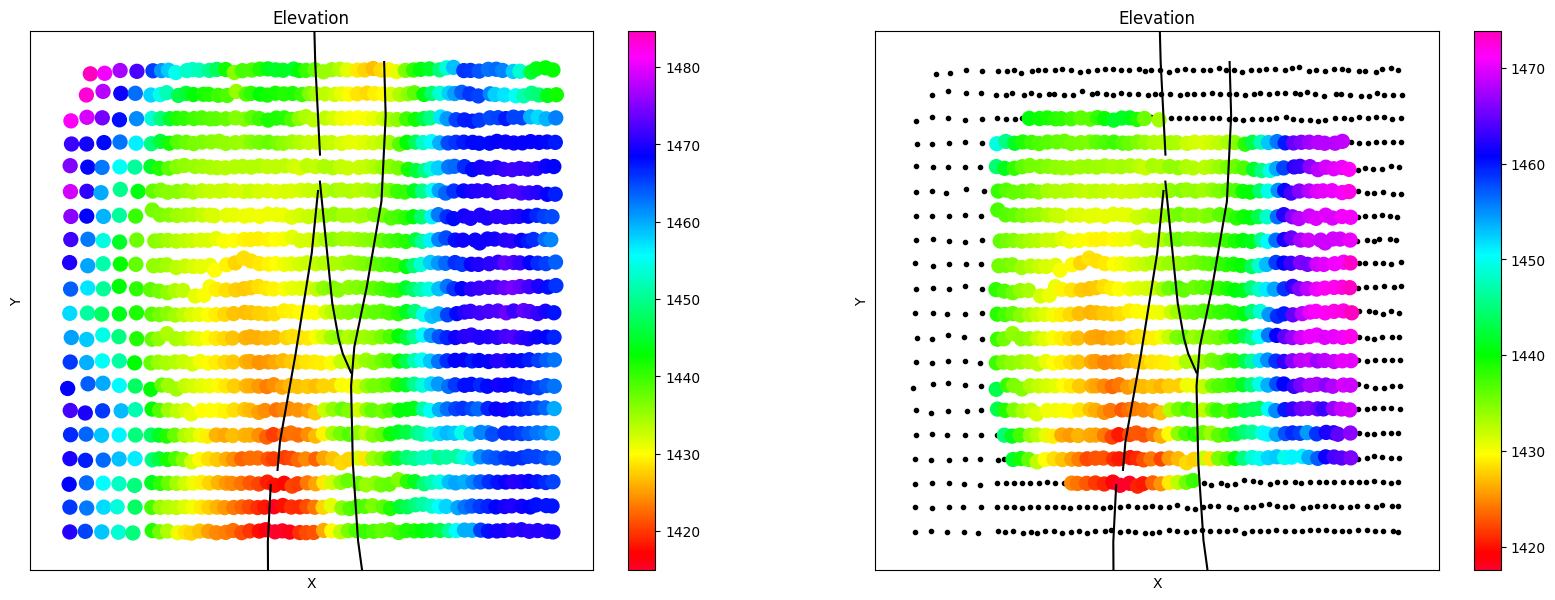

In [17]:
fig = plt.figure(figsize=(20, 7))
ax  = fig.add_subplot(121)
ax.scatter(x_stations_all_new, y_stations_all_new,marker='.',color='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Elevation')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
for j in range(len(faults)):
    ax.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
im = ax.scatter(x_stations_all_new,y_stations_all_new,c=elevation_stations_all_new,cmap='gist_rainbow',s=100)
plt.colorbar(im)

ax  = fig.add_subplot(122)
ax.scatter(x_stations_all_new, y_stations_all_new,marker='.',color='k')
ax.set_xticks([])  #去掉横坐标值
ax.set_yticks([])  #去掉纵坐标值
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Elevation')
ax.set_xlim(-50,650)
ax.set_ylim(-50,650)
for j in range(len(faults)):
    ax.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
im = ax.scatter(x_stations_in,y_stations_in,c=elevation_stations_in,cmap='gist_rainbow',s=100)
plt.colorbar(im)

### Do clipper

In [18]:
# define traces
traces = {}
for i in range(4,18):
    y = 30*(i-1)
    traces[i] = np.zeros([2,2])
    traces[i][0,0] = np.min(x_inter_in)
    traces[i][0,1] = y
    traces[i][1,0] = np.max(x_inter_in)
    traces[i][1,1] = y

In [19]:
def extract_points(tag_trace,x_inter_in,y_inter_in):
    global traces
    trace = traces[tag_trace]

    x1 = trace[0,0]
    y1 = trace[0,1]
    x2 = trace[1,0]
    y2 = trace[1,1]
    A = (y2-y1)/(x2-x1)
    B = -1
    C = y2 - A*x2

    flag_r = np.sqrt(( (y_inter_in[1]-y_inter_in[0])**2 + (x_inter_in[1]-x_inter_in[0])**2 ))/2
    index = []
    
    for i in range(len(x_inter_in)):
        x0 = x_inter_in[i]
        y0 = y_inter_in[i]
        d = abs(A*x0+B*y0+C)/math.sqrt(A**2+B**2)
        if d <= flag_r:
            index.append(i)
    return index

In [20]:
def find_intersection_point(point1_line, point2_line, external_point):
    # 计算直线的斜率
    line_slope = (point2_line[1] - point1_line[1]) / (point2_line[0] - point1_line[0])
    
    if line_slope == 0:
        #print('slope == 0')
        #print(external_point[1],point1_line[0])
        return  point1_line[0],external_point[1]
    # 计算直线的截距
    line_intercept = point1_line[1] - line_slope * point1_line[0]

    # 计算垂线的斜率
    perpendicular_slope = -1 / line_slope

    # 计算垂线的截距
    perpendicular_intercept = external_point[1] - perpendicular_slope * external_point[0]

    # 求解方程组以找到交点
    intersection_x = (perpendicular_intercept - line_intercept) / (line_slope - perpendicular_slope)
    intersection_y = line_slope * intersection_x + line_intercept

    return intersection_x, intersection_y

In [21]:
x_inter_verti = {}
y_inter_verti = {}
vs_inter_verti = {}
vs_inter_fund_verti = {}   
if flag_smooth == 1:
    vs_smooth_inter_verti = {}
    vs_fund_smooth_inter_verti = {}
ele_verti = {}
indexes = {}
loc_starts = {}
for tag in traces.keys():
    print(tag)
    #index = extract_points(tag,x_inter_in,y_inter_in)
    yy = list(set(y_inter_in))
    index_this = np.argmin(np.abs(yy-traces[tag][0][1]))
    index = np.where(y_inter_in == yy[index_this])[0]
    
    indexes[tag] = index
    x_inter_verti[tag] = np.array(x_inter_in)[index]
    y_inter_verti[tag] = np.array(y_inter_in)[index]
    
    vs_inter_verti[tag] = []
    vs_inter_fund_verti[tag] = []
    ele_verti[tag] = []
    loc_start = find_intersection_point(traces[tag][0], traces[tag][1], [x_inter_verti[tag][0], y_inter_verti[tag][0]])
    loc_starts[tag] = loc_start
    for i in range(N):
        vs_inter_verti[tag].append(vs[i,index])
        vs_inter_fund_verti[tag].append(vs_fund[i,index])
    if flag_smooth == 1:
        vs_smooth_inter_verti[tag] = []
        vs_fund_smooth_inter_verti[tag] = []
        for i in range(N):
            vs_smooth_inter_verti[tag].append(vs_smooth[i,index])
            vs_fund_smooth_inter_verti[tag].append(vs_fund_smooth[i,index])
    ele_verti[tag].append(np.array(ele_inter_in)[index])

4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [22]:
# 判断两条线段是否相交
def cross_product(p1, p2, p3):
    """计算叉积"""
    return (p2[0] - p1[0]) * (p3[1] - p1[1]) - (p2[1] - p1[1]) * (p3[0] - p1[0])

def on_segment(p1, p2, p3):
    """检查p2是否在以p1和p3为端点的线段上"""
    print('on segement')
    return min(p1[0], p3[0]) <= p2[0] <= max(p1[0], p3[0]) and min(p1[1], p3[1]) <= p2[1] <= max(p1[1], p3[1])

def segments_intersect(p1, q1, p2, q2):
    """检查由(p1, q1)和(p2, q2)形成的两条线段是否相交"""
    # 检查线段的方向
    o1 = cross_product(p1, q1, p2)
    o2 = cross_product(p1, q1, q2)
    o3 = cross_product(p2, q2, p1)
    o4 = cross_product(p2, q2, q1)

    # 如果两条线段的方向相异，则它们相交
    if o1 * o2 < 0 and o3 * o4 < 0:
        return True
    # 特殊情况处理
    if o1 == 0 and on_segment(p1, p2, q1):
        return True
    if o2 == 0 and on_segment(p1, q2, q1):
        return True
    if o3 == 0 and on_segment(p2, p1, q2):
        return True
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    return False

def plot_segments(p1, q1, p2, q2):
    plt.plot([p1[0], q1[0]], [p1[1], q1[1]], color='blue', label='Segment 1')
    plt.plot([p2[0], q2[0]], [p2[1], q2[1]], color='red', label='Segment 2')

    intersection = segments_intersect(p1, q1, p2, q2)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Segments Intersection')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [23]:
def find_fault_inter(tag_trace):
    global traces
    global faults
    global x_faults
    global y_faults
    global x_inter_verti
    global y_inter_verti

    x_fault_inter = []
    y_fault_inter = []

    for key in faults.keys():
        x_fault = x_faults[key]
        y_fault = y_faults[key]
        index_fault_start = np.argmin(y_fault)
        index_fault_end = np.argmax(y_fault)
        p1 = [x_fault[index_fault_start], y_fault[index_fault_start]]
        q1 = [x_fault[index_fault_end], y_fault[index_fault_end]]
        index_trace_start = np.argmin(x_inter_verti[tag_trace])
        index_trace_end = np.argmax(x_inter_verti[tag_trace])
        p2 = [x_inter_verti[tag_trace][index_trace_start], y_inter_verti[tag_trace][index_trace_start]]
        q2 = [x_inter_verti[tag_trace][index_trace_end], y_inter_verti[tag_trace][index_trace_end]]
        
        if segments_intersect(p1, q1, p2, q2):
            # find the nearest fault point
            x_trace = x_inter_verti[tag_trace]
            y_trace = y_inter_verti[tag_trace]

            min_distance = float('inf')

            for lon1, lat1 in zip(x_fault, y_fault):
                for lon2, lat2 in zip(x_trace, y_trace):
                    distance = math.sqrt((lon1 - lon2)**2 + (lat1 - lat2)**2)
                    if distance < min_distance:
                        min_distance = distance
                        x_fault_near = lon1
                        y_fault_near = lat1
                        x_trace_near = lon2
                        y_trace_near = lat2
                    
            x_fault_inter.append( x_trace_near )
            y_fault_inter.append( y_trace_near )
        
        """
        intersection = find_lines_inter(p1, q1, p2, q2)
        if intersection is not None:
            lon_fault_inter.append(intersection[0])
            lat_fault_inter.append(intersection[1])
        """
    return x_fault_inter, y_fault_inter

In [24]:
v_min = 0.45
v_max = 1.1
#v_min = 0.3
#v_max = 0.9
cmap = 'jet'
#cmap = 'gist_rainbow'

In [25]:
for i in list(traces.keys()):
    print('Plotting trace %d' % i)
    fig = plt.figure(figsize=(20, 10))

    ax1 = plt.subplot2grid((18,3),(2,0),colspan=2,rowspan=7)
    im = ax1.imshow(vs_inter_fund_verti[i], aspect='auto', cmap=cmap, extent=[np.min(x_inter_verti[i]),np.max(x_inter_verti[i]),N*dz,0], vmin=v_min, vmax=v_max)
    ax1.set_xticks([])  #去掉横坐标值
    ax1.set_ylabel('Depth /m Fundamental')
    ax1.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])
    # 找到断层点
    x_fault_inter, y_fault_inter = find_fault_inter(i)
    for j in range(len(x_fault_inter)):
        ax1.vlines(x_fault_inter[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
    ax1.set_title('Fundamental')
    plt.colorbar(im,orientation='horizontal',aspect=100,fraction=0.05,pad=0.05)


    ax2 = plt.subplot2grid((18,3),(10,0),colspan=2,rowspan=8)
    im = ax2.imshow(vs_inter_verti[i], aspect='auto', cmap=cmap, extent=[np.min(x_inter_verti[i]),np.max(x_inter_verti[i]),N*dz,0], vmin=v_min, vmax=v_max)
    #ax3.set_xticks([])  #去掉横坐标值
    ax2.set_xlabel('Offset')
    ax2.set_ylabel('Depth /m Overtones')
    ax2.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])
    # 找到断层点
    #lon_fault_inter, lat_fault_inter = find_fault_inter(i)
    for j in range(len(x_fault_inter)):
        ax2.vlines(x_fault_inter[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
    ax2.set_title('Overtones')
    


    axele = plt.subplot2grid((18,3),(0,0),colspan=2,rowspan=1)
    axele.set_xticks([])  #去掉横坐标值
    #axele.set_yticks([])  #去掉纵坐标值
    axele.set_ylabel('Elev')
    axele.spines['top'].set_visible(False)
    

    # 画ele的柱状图
    #index_r = np.argsort(r_ele[i])
    #axele.plot(r_ele[i][index_r], ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k')
    #axele.fill_between(r_ele[i][index_r], 0, ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k', alpha=0.5)
    
    axele.plot(x_inter_verti[i],ele_verti[i][0]-min(ele_verti[i][0]),color='k')
    axele.fill_between(x_inter_verti[i],0,ele_verti[i][0]-min(ele_verti[i][0]),color='k',alpha = 0.5)
    for j in range(len(x_fault_inter)):
        axele.vlines(x_fault_inter[j], 0, max(ele_verti[i][0]-min(ele_verti[i][0])), colors = "k", linestyles = "dashed")
    axele.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])

    ax3 = plt.subplot2grid((2,3),(0,2),colspan=1,rowspan=1)
    ax3.scatter(x_stations_all_new, y_stations_all_new, c='k', s=0.08)
    for j in range(len(faults)):
        ax3.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
    ax3.scatter(x_inter_in, y_inter_in, c='b', s=0.1)
    ax3.scatter(np.array(x_inter_in)[indexes[i]], np.array(y_inter_in)[indexes[i]], c='r', s=0.3)
    ax3.scatter(x_fault_inter, y_fault_inter, c='y', s=50)
    ax3.set_xlim(-50,650)
    ax3.set_ylim(-50,650)
    ax3.set_xticks([])  #去掉横坐标值
    ax3.set_yticks([])  #去掉纵坐标值
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')


    ax4 = plt.subplot2grid((2,3),(1,2),colspan=1,rowspan=1)
    ax4.scatter(x_stations_all_new, y_stations_all_new,marker='.',color='k',s=0.08)
    ax4.set_xticks([])  #去掉横坐标值
    ax4.set_yticks([])  #去掉纵坐标值
    ax4.set_xlabel('X')
    ax4.set_ylabel('Y')
    ax4.set_title('Elevation')
    ax4.set_xlim(-50,650)
    ax4.set_ylim(-50,650)
    for j in range(len(faults)):
        ax4.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
    im = ax4.scatter(x_stations_in,y_stations_in,c=elevation_stations_in,cmap=cmap,s=20)
    ax4.plot(np.array(x_inter_in)[indexes[i]], np.array(y_inter_in)[indexes[i]], c='b')
    #plt.colorbar(im, ax=ax4, location='top', shrink=0.6)
 
    cax = inset_axes(ax4,
                 width="1%",  # colorbar宽度占主轴宽度的百分比
                 height="50%",  # colorbar高度占主轴高度的百分比
                 loc='upper right')  # 在右上角放置colorbar
    cbar = plt.colorbar(im, cax=cax, orientation='vertical')
    #plt.tight_layout()
    plt.savefig(dir_image+'Vs_verticle_trace_'+str(i)+'.png')
    #plt.savefig(dir_image+'Vs_shallow_verticle_trace_'+str(i)+'.png')
    plt.close()

Plotting trace 4


Plotting trace 5
Plotting trace 6
Plotting trace 7
Plotting trace 8
Plotting trace 9
Plotting trace 10
Plotting trace 11
Plotting trace 12
Plotting trace 13
Plotting trace 14
Plotting trace 15
Plotting trace 16
Plotting trace 17


In [26]:
if flag_smooth == 1:
    for i in list(traces.keys()):
        print('Plotting trace %d' % i)
        fig = plt.figure(figsize=(20, 10))

        ax1 = plt.subplot2grid((18,3),(2,0),colspan=2,rowspan=7)
        im = ax1.imshow(vs_fund_smooth_inter_verti[i], aspect='auto', cmap=cmap, extent=[np.min(x_inter_verti[i]),np.max(x_inter_verti[i]),N*dz,0], vmin=v_min, vmax=v_max)
        ax1.set_xticks([])  #去掉横坐标值
        ax1.set_ylabel('Depth /m Fundamental')
        ax1.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])
        # 找到断层点
        x_fault_inter, y_fault_inter = find_fault_inter(i)
        for j in range(len(x_fault_inter)):
            ax1.vlines(x_fault_inter[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
        ax1.set_title('Fundamental')
        plt.colorbar(im,orientation='horizontal',aspect=100,fraction=0.05,pad=0.05)


        ax2 = plt.subplot2grid((18,3),(10,0),colspan=2,rowspan=8)
        im = ax2.imshow(vs_smooth_inter_verti[i], aspect='auto', cmap=cmap, extent=[np.min(x_inter_verti[i]),np.max(x_inter_verti[i]),N*dz,0], vmin=v_min, vmax=v_max)
        #ax3.set_xticks([])  #去掉横坐标值
        ax2.set_xlabel('Offset')
        ax2.set_ylabel('Depth /m Overtones')
        ax2.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])
        # 找到断层点
        #lon_fault_inter, lat_fault_inter = find_fault_inter(i)
        for j in range(len(x_fault_inter)):
            ax2.vlines(x_fault_inter[j], 0, N/10*dz, colors = "k", linestyles = "dashed")
        ax2.set_title('Overtones')
        


        axele = plt.subplot2grid((18,3),(0,0),colspan=2,rowspan=1)
        axele.set_xticks([])  #去掉横坐标值
        #axele.set_yticks([])  #去掉纵坐标值
        axele.set_ylabel('Elev')
        axele.spines['top'].set_visible(False)
        

        # 画ele的柱状图
        #index_r = np.argsort(r_ele[i])
        #axele.plot(r_ele[i][index_r], ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k')
        #axele.fill_between(r_ele[i][index_r], 0, ele_verti[i][0][index_r]-min(ele_verti[i][0]), color='k', alpha=0.5)
        
        axele.plot(x_inter_verti[i],ele_verti[i][0]-min(ele_verti[i][0]),color='k')
        axele.fill_between(x_inter_verti[i],0,ele_verti[i][0]-min(ele_verti[i][0]),color='k',alpha = 0.5)
        for j in range(len(x_fault_inter)):
            axele.vlines(x_fault_inter[j], 0, max(ele_verti[i][0]-min(ele_verti[i][0])), colors = "k", linestyles = "dashed")
        axele.set_xlim([np.min(x_inter_in),np.max(x_inter_in)])

        ax3 = plt.subplot2grid((2,3),(0,2),colspan=1,rowspan=1)
        ax3.scatter(x_stations_all_new, y_stations_all_new, c='k', s=0.08)
        for j in range(len(faults)):
            ax3.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
        ax3.scatter(x_inter_in, y_inter_in, c='b', s=0.1)
        ax3.scatter(np.array(x_inter_in)[indexes[i]], np.array(y_inter_in)[indexes[i]], c='r', s=0.3)
        ax3.scatter(x_fault_inter, y_fault_inter, c='y', s=50)
        ax3.set_xlim(-50,650)
        ax3.set_ylim(-50,650)
        ax3.set_xticks([])  #去掉横坐标值
        ax3.set_yticks([])  #去掉纵坐标值
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')


        ax4 = plt.subplot2grid((2,3),(1,2),colspan=1,rowspan=1)
        ax4.scatter(x_stations_all_new, y_stations_all_new,marker='.',color='k',s=0.08)
        ax4.set_xticks([])  #去掉横坐标值
        ax4.set_yticks([])  #去掉纵坐标值
        ax4.set_xlabel('X')
        ax4.set_ylabel('Y')
        ax4.set_title('Elevation')
        ax4.set_xlim(-50,650)
        ax4.set_ylim(-50,650)
        for j in range(len(faults)):
            ax4.plot(x_faults['clark'+str(j+1)], y_faults['clark'+str(j+1)], 'k')
        im = ax4.scatter(x_stations_in,y_stations_in,c=elevation_stations_in,cmap=cmap,s=20)
        ax4.plot(np.array(x_inter_in)[indexes[i]], np.array(y_inter_in)[indexes[i]], c='b')
        #plt.colorbar(im, ax=ax4, location='top', shrink=0.6)
    
        cax = inset_axes(ax4,
                    width="1%",  # colorbar宽度占主轴宽度的百分比
                    height="50%",  # colorbar高度占主轴高度的百分比
                    loc='upper right')  # 在右上角放置colorbar
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        #plt.tight_layout()
        plt.savefig(dir_image+'Vs_verticle_trace_'+str(i)+'_smooth.png')
        #plt.savefig(dir_image+'Vs_shallow_verticle_trace_'+str(i)+'.png')
        plt.close()

Plotting trace 4
Plotting trace 5
Plotting trace 6
Plotting trace 7
Plotting trace 8
Plotting trace 9
Plotting trace 10
Plotting trace 11
Plotting trace 12
Plotting trace 13
Plotting trace 14
Plotting trace 15
Plotting trace 16
Plotting trace 17
